# Neural network with PyTorch

Example based on https://jovian.ai/aakashns/mnist-logistic-minimal

In [1]:
# Imports
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28 # the size of the images
num_classes = 10 # the numbers 0-9

## Dataset & Data loaders

In [3]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

Label: 4


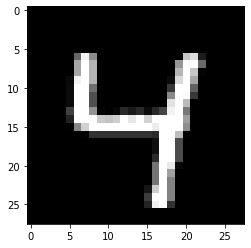

In [4]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

## Model

In [12]:
class NeuralNetwork(nn.Module):
	def __init__(self):
		super().__init__()
		self.linear = nn.Linear(input_size, num_classes)

	def forward(self, xb):
		xb = xb.reshape(-1, 784)
		out = self.linear(xb)
		return out

	def training_step(self, batch):
		images, labels = batch 
		out = self(images)                  # Generate predictions
		loss = F.cross_entropy(out, labels) # Calculate loss
		return loss
	
	def predict(self, img):
		xb = img.unsqueeze(0)
		yb = model(xb)
		return yb.detach().numpy()

	def train(self, epochs, lr, train_loader, val_loader, opt_func=torch.optim.SGD):
		history = []
		optimizer = opt_func(self.parameters(), lr)
		for epoch in range(epochs):
			# Training Phase 
			for batch in train_loader:
				loss = self.training_step(batch)
				loss.backward()
				self.update_weights(optimizer)
				
			# Validation phase
			result = self.evaluate(val_loader)
			self.epoch_end(epoch, result)
			history.append(result)
		return history    

	def update_weights(self,optimizer):
		optimizer.step()
		optimizer.zero_grad()

	def accuracy(self, outputs, labels):
		_, preds = torch.max(outputs, dim=1)
		return torch.tensor(torch.sum(preds == labels).item() / len(preds))

	def evaluate(self, val_loader):
		outputs = [self.validation_step(batch) for batch in val_loader]
		return self.validation_epoch_end(outputs)

	def validation_step(self, batch):
		images, labels = batch 
		out = self(images)                    # Generate predictions
		loss = F.cross_entropy(out, labels)   # Calculate loss
		acc = self.accuracy(out, labels)           # Calculate accuracy
		return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

	def validation_epoch_end(self, outputs):
		batch_losses = [x['val_loss'] for x in outputs]
		epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
		batch_accs = [x['val_acc'] for x in outputs]
		epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
		return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

	def epoch_end(self, epoch, result):
		print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = NeuralNetwork()

## Training

In [13]:
history = model.train(5, 0.001, train_loader, val_loader)

Epoch [0], val_loss: 1.9430, val_acc: 0.6288
Epoch [1], val_loss: 1.6747, val_acc: 0.7212
Epoch [2], val_loss: 1.4755, val_acc: 0.7583
Epoch [3], val_loss: 1.3253, val_acc: 0.7799
Epoch [4], val_loss: 1.2097, val_acc: 0.7927


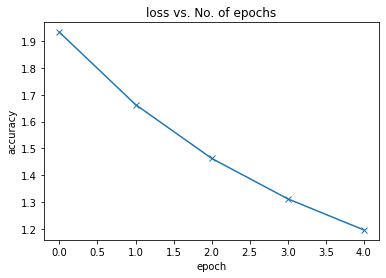

In [162]:
losses = [r['val_loss'] for r in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('loss vs. No. of epochs');

## Prediction

Label: 9 , Predicted: [9]


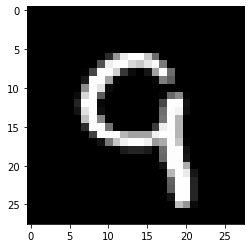

In [163]:
img, label = test_ds[913]
plt.imshow(img[0], cmap='gray')
predictions = model.predict(img)
prediction = predictions.argmax(axis=1)
print('Label:', label, ', Predicted:', predictions.argmax(axis=1))

## Save weights

In [18]:
# torch.save(model.state_dict(), 'mnist-logistic.pth')